# Image segmentation (3D UNET)
- 이번 실습에서는 3D U-NET을 이용하여 brain MRI image로부터 tumor region을 segmentation하는 model을 학습합니다.
- Generality를 높이기 위한 input data에 대한 transform을 추가해보도록 합니다.
- 3D U-NET의 구조를 바꾸어 보고, 다른 3D segmentation model을 적용하여 학습과정 및 결과를 비교합니다.
- Loss function을 다르게 적용하여 이에 의한 영향을 확인해 봅니다. 
- MONAI에서 제공하는 다른 segmentation예제들을 참고해 봅니다.
  - https://github.com/Project-MONAI/tutorials/tree/master/3d_segmentation


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 714 kB 5.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path0 = '/content/drive/Shareddrives/Project/brats18_train' # replace your data path
path_t = '/content/drive/Shareddrives/Project/brats18_test'
dpiv = 80

In [ ]:
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    AddChanneld,
    CenterSpatialCropd,
    RandAffined,
    RandGaussianNoised,
    RandGaussianSmoothd,
    ToTensord,
    SqueezeDimd,
    RandCropByPosNegLabeld,
    RandBiasFieldd,
    RandGaussianSharpend,
    RandRotate90d

)
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first

from monai.losses import DiceLoss
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

100

In [ ]:
path_test = glob.glob(os.path.join(path_t,'Brats18*'))
len(path_test)

20

### data split (train/valid)

In [ ]:
train_ind = np.arange(0,80)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [ ]:
valid_ind = np.arange(80,100)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in valid_ind
]
valid_files =  data_dicts

In [ ]:
test_ind = np.arange(0,20)
data_dicts = [
    {
        "image": os.path.join(path_test[idx],
                                    "t1ce.nii.gz"),
    }
    for idx in test_ind
]
test_files =  data_dicts

In [ ]:
#data transformation - important, model의 generality 증가
roi_size = (160, 160, 64)

train_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=roi_size,
            pos=3,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
       RandGaussianNoised(
        keys = ["image"],
        mean = 0.0,
        std = 0.1,
        prob = 0.2
       ),
       RandBiasFieldd(
        keys = ["image"],
        prob = 0.2
        ),
       RandGaussianSharpend(
        keys = ["image"],
        prob = 0.1
        ),
      #CenterSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 96]),
      #RandSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 64],random_size=False),
     


        #ConvertToMultiChannel(keys="label"),
        RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=2),
        RandRotate90d(
        keys=["image", "label"],
        prob=0.10,
        max_k=3,),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1., 1.,1.),
            mode=("bilinear","nearest"),
        ),
        
        RandAffined( 
            keys=["image","label"],
            prob=0.1,   
            spatial_size=roi_size,                    
            translate_range=(15,15,2), 
            shear_range = (0.2,0.2,0.2),
            scale_range=(0.15, 0.15, 0.15),
            padding_mode='zeros',
            mode = ("bilinear","nearest")),
   
        
        Orientationd(keys=["image","label"], axcodes="RAS"),

       # ResizeWithPadOrCropd(keys=["image","label"],spatial_size=(256,256,48)),  ##사이즈어떻게?
        
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        
        #RandGaussianNoised(keys=["image"],std=0.125,prob=0.5),
        #RandShiftIntensityd(keys=["image"], offsets=(-.05,.05), prob=.75),
        #RandScaleIntensityd(keys=["image"], factors=(-.75,1.25), prob=.75),
        #RandGaussianSmoothd(keys=["image"],sigma_x=(0.25,.5),sigma_y=(0.25,.5),sigma_z=(0.25,.5),prob=0.5),
        EnsureTyped(keys=["image", "label"]),
        
        ToTensord(keys=["image", "label"]),
     
    ]

)

valid_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      

     ######

      #ConvertToMultiChannel(keys="label"),
       
        Spacingd(
            keys=["image", "label"],
            pixdim=(1., 1., 1.),
            mode=("bilinear","nearest"),
        ),     
     
        Orientationd(keys=["image", "label"], axcodes="RAS"),
       # ResizeWithPadOrCropd(keys=["image","label"],spatial_size=(256,256,48)),    ############(256,256,48)
     

        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
     
    ]
)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
test_transforms = Compose(
    [
      LoadImaged(keys=("image")),
      AddChanneld(keys=("image")),
      #SqueezeDimd(keys=["grem","up"],dim=-1),

     ######

      #ConvertToMultiChannel(keys="label"),
       
        Spacingd(
            keys=["image"],
            pixdim=(1., 1., 1.),
            mode=("bilinear"),
        ),     
     
        Orientationd(keys=["image"], axcodes="RAS"),
       # ResizeWithPadOrCropd(keys=["image","label"],spatial_size=(256,256,48)),    ############(256,256,48)
     

        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image"]),
     
    ]
)

In [ ]:
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds,batch_size = 2)

In [ ]:
valid_ds = Dataset(data = valid_files, transform = valid_transforms)
valid_loader = DataLoader(valid_ds,batch_size = 1)

In [ ]:
test_ds = Dataset(data = test_files, transform = test_transforms)
#test_loader = DataLoader(test_ds,batch_size = 1)
test_loader = DataLoader(test_ds,batch_size = 1,num_workers=2)

- transform이 제대로 적용되는 지 확인해 봅니다.

torch.Size([8, 1, 160, 160, 64])
torch.Size([8, 1, 160, 160, 64])


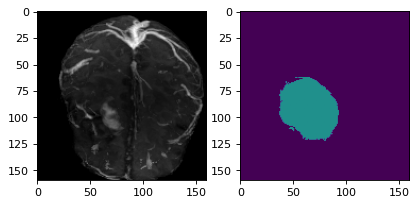

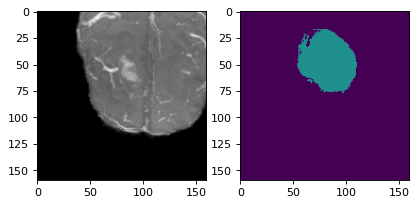

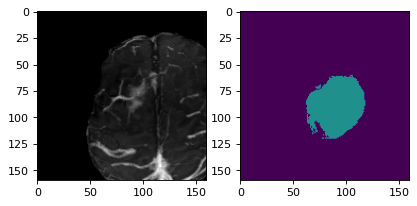

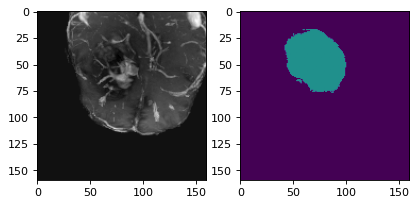

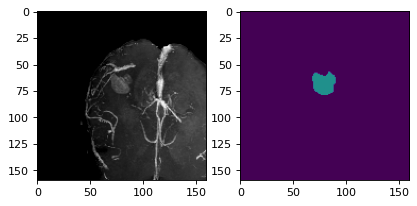

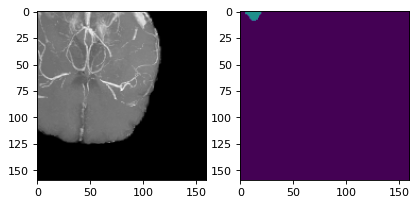

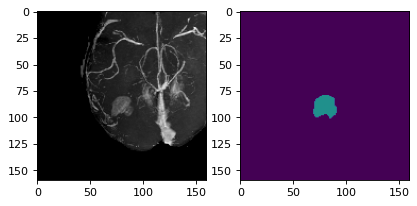

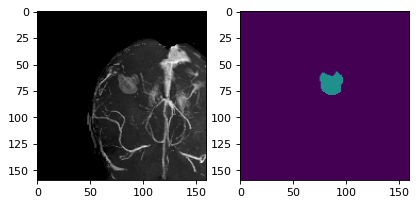

In [ ]:
cnt = 0
for data in train_loader:
  print(data["image"].shape)
  print(data["label"].shape)

  for n in range(0,len(data["image"])):
    plt.figure(dpi=dpiv)
    plt.subplot(121)
    plt.imshow(np.transpose(np.max(data["image"][n,0,:,:,:].numpy(),axis=2),(1,0)),cmap='gray')
                              #maximum intensity transform 적용

    label = (data["label"]==1).type(torch.FloatTensor) + (data["label"]==4).type(torch.FloatTensor) 
    plt.subplot(122)
    plt.imshow(np.transpose(np.max(label[n,0,:,:,:].numpy(),axis=2),(1,0)),vmin=0,vmax=2)
    plt.show()

  break
 

# Model

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

#UNet의 모델을 바꿔도되고, 파라미터값을 바꿔도되고
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2, #tumor & background
    channels=(16, 32, 64, 128, 256),
    #channels=(8, 16, 32, 64),
    #channels=(16, 32, 64, 128),#8,16,32,64
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)  #sigmoid? 성능 괜찮은데 나중에 저장하는데 argmax말고 딴거해야할듯
#loss_function = DiceCELoss(include_background=False, softmax = True, to_onehot_y = True)


# Train

----------
epoch 1/150
epoch 1 average loss: 0.6368
----------
epoch 2/150
epoch 2 average loss: 0.6054
----------
epoch 3/150
epoch 3 average loss: 0.5893
----------
epoch 4/150
epoch 4 average loss: 0.5755
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


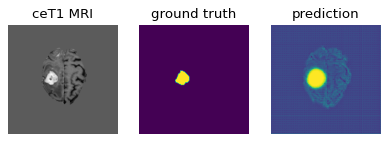

saved new best metric model
current epoch: 4 current mean dice: 0.4319
best mean dice: 0.4319 at epoch: 4
----------
epoch 5/150
epoch 5 average loss: 0.5642
----------
epoch 6/150
epoch 6 average loss: 0.5534
----------
epoch 7/150
epoch 7 average loss: 0.5420
----------
epoch 8/150
epoch 8 average loss: 0.5321
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


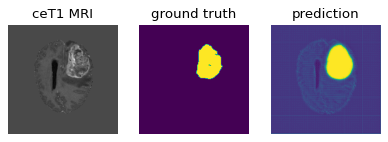

saved new best metric model
current epoch: 8 current mean dice: 0.4684
best mean dice: 0.4684 at epoch: 8
----------
epoch 9/150
epoch 9 average loss: 0.5219
----------
epoch 10/150
epoch 10 average loss: 0.5119
----------
epoch 11/150
epoch 11 average loss: 0.5040
----------
epoch 12/150
epoch 12 average loss: 0.4955
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


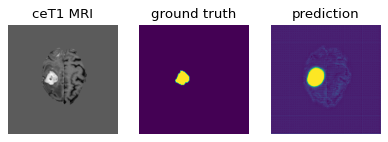

saved new best metric model
current epoch: 12 current mean dice: 0.4932
best mean dice: 0.4932 at epoch: 12
----------
epoch 13/150
epoch 13 average loss: 0.4815
----------
epoch 14/150
epoch 14 average loss: 0.4747
----------
epoch 15/150
epoch 15 average loss: 0.4684
----------
epoch 16/150
epoch 16 average loss: 0.4551
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


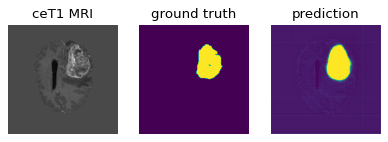

saved new best metric model
current epoch: 16 current mean dice: 0.5200
best mean dice: 0.5200 at epoch: 16
----------
epoch 17/150
epoch 17 average loss: 0.4492
----------
epoch 18/150
epoch 18 average loss: 0.4371
----------
epoch 19/150
epoch 19 average loss: 0.4270
----------
epoch 20/150
epoch 20 average loss: 0.4180
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


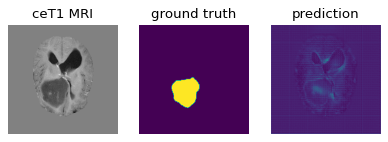

saved new best metric model
current epoch: 20 current mean dice: 0.5502
best mean dice: 0.5502 at epoch: 20
----------
epoch 21/150
epoch 21 average loss: 0.4019
----------
epoch 22/150
epoch 22 average loss: 0.3882
----------
epoch 23/150
epoch 23 average loss: 0.3700
----------
epoch 24/150
epoch 24 average loss: 0.3644
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


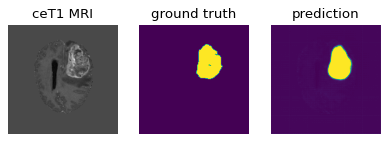

saved new best metric model
current epoch: 24 current mean dice: 0.5992
best mean dice: 0.5992 at epoch: 24
----------
epoch 25/150
epoch 25 average loss: 0.3577
----------
epoch 26/150
epoch 26 average loss: 0.3411
----------
epoch 27/150
epoch 27 average loss: 0.3213
----------
epoch 28/150
epoch 28 average loss: 0.3212
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


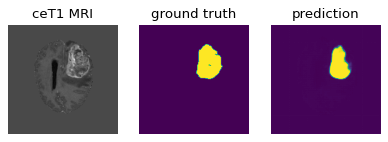

saved new best metric model
current epoch: 28 current mean dice: 0.6172
best mean dice: 0.6172 at epoch: 28
----------
epoch 29/150
epoch 29 average loss: 0.2923
----------
epoch 30/150
epoch 30 average loss: 0.2763
----------
epoch 31/150
epoch 31 average loss: 0.2803
----------
epoch 32/150
epoch 32 average loss: 0.2531
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


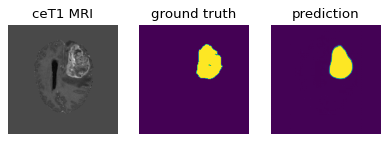

saved new best metric model
current epoch: 32 current mean dice: 0.6940
best mean dice: 0.6940 at epoch: 32
----------
epoch 33/150
epoch 33 average loss: 0.2472
----------
epoch 34/150
epoch 34 average loss: 0.2345
----------
epoch 35/150
epoch 35 average loss: 0.2290
----------
epoch 36/150
epoch 36 average loss: 0.2060
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


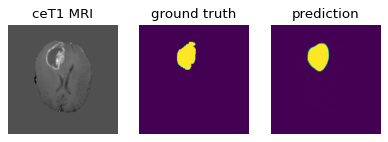

saved new best metric model
current epoch: 36 current mean dice: 0.7533
best mean dice: 0.7533 at epoch: 36
----------
epoch 37/150
epoch 37 average loss: 0.2006
----------
epoch 38/150
epoch 38 average loss: 0.1982
----------
epoch 39/150
epoch 39 average loss: 0.1851
----------
epoch 40/150
epoch 40 average loss: 0.1811
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


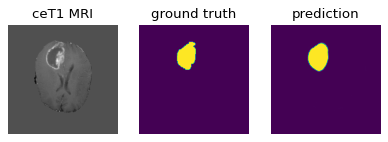

saved new best metric model
current epoch: 40 current mean dice: 0.7920
best mean dice: 0.7920 at epoch: 40
----------
epoch 41/150
epoch 41 average loss: 0.1795
----------
epoch 42/150
epoch 42 average loss: 0.1584
----------
epoch 43/150
epoch 43 average loss: 0.1579
----------
epoch 44/150
epoch 44 average loss: 0.1594
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_375_1/t1ce.nii.gz']


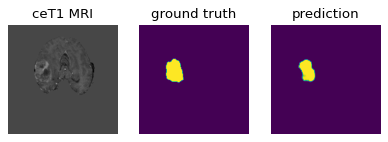

saved new best metric model
current epoch: 44 current mean dice: 0.7939
best mean dice: 0.7939 at epoch: 44
----------
epoch 45/150
epoch 45 average loss: 0.1592
----------
epoch 46/150
epoch 46 average loss: 0.1513
----------
epoch 47/150
epoch 47 average loss: 0.1507
----------
epoch 48/150
epoch 48 average loss: 0.1433
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_205_1/t1ce.nii.gz']


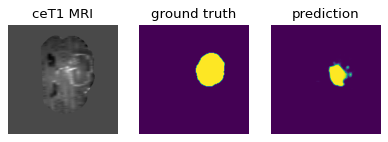

saved new best metric model
current epoch: 48 current mean dice: 0.8281
best mean dice: 0.8281 at epoch: 48
----------
epoch 49/150
epoch 49 average loss: 0.1460
----------
epoch 50/150
epoch 50 average loss: 0.1311
----------
epoch 51/150
epoch 51 average loss: 0.1376
----------
epoch 52/150
epoch 52 average loss: 0.1387
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


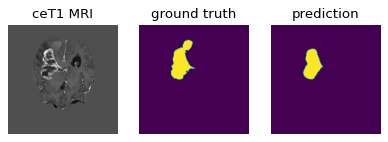

saved new best metric model
current epoch: 52 current mean dice: 0.8530
best mean dice: 0.8530 at epoch: 52
----------
epoch 53/150
epoch 53 average loss: 0.1364
----------
epoch 54/150
epoch 54 average loss: 0.1372
----------
epoch 55/150
epoch 55 average loss: 0.1301
----------
epoch 56/150
epoch 56 average loss: 0.1357
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


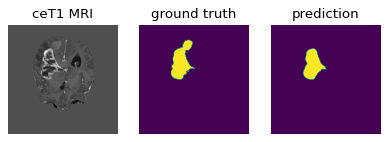

saved new best metric model
current epoch: 56 current mean dice: 0.8612
best mean dice: 0.8612 at epoch: 56
----------
epoch 57/150
epoch 57 average loss: 0.1245
----------
epoch 58/150
epoch 58 average loss: 0.1168
----------
epoch 59/150
epoch 59 average loss: 0.1139
----------
epoch 60/150
epoch 60 average loss: 0.1177
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_278_1/t1ce.nii.gz']


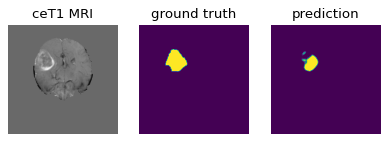

saved new best metric model
current epoch: 60 current mean dice: 0.8758
best mean dice: 0.8758 at epoch: 60
----------
epoch 61/150
epoch 61 average loss: 0.1321
----------
epoch 62/150
epoch 62 average loss: 0.1198
----------
epoch 63/150
epoch 63 average loss: 0.1147
----------
epoch 64/150
epoch 64 average loss: 0.1320
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_257_1/t1ce.nii.gz']


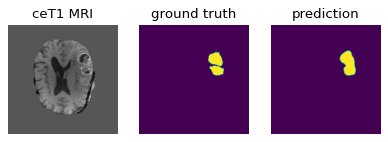

saved new best metric model
current epoch: 64 current mean dice: 0.8783
best mean dice: 0.8783 at epoch: 64
----------
epoch 65/150
epoch 65 average loss: 0.1138
----------
epoch 66/150
epoch 66 average loss: 0.1029
----------
epoch 67/150
epoch 67 average loss: 0.1059
----------
epoch 68/150
epoch 68 average loss: 0.1016
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


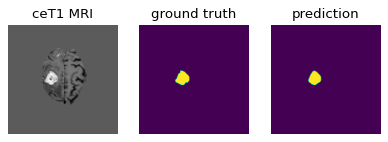

saved new best metric model
current epoch: 68 current mean dice: 0.8807
best mean dice: 0.8807 at epoch: 68
----------
epoch 69/150
epoch 69 average loss: 0.1080
----------
epoch 70/150
epoch 70 average loss: 0.1075
----------
epoch 71/150
epoch 71 average loss: 0.1135
----------
epoch 72/150
epoch 72 average loss: 0.1010
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


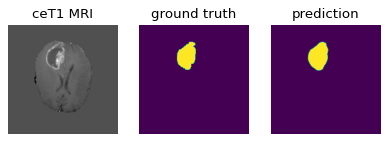

current epoch: 72 current mean dice: 0.8766
best mean dice: 0.8807 at epoch: 68
----------
epoch 73/150
epoch 73 average loss: 0.1003
----------
epoch 74/150
epoch 74 average loss: 0.0967
----------
epoch 75/150
epoch 75 average loss: 0.1061
----------
epoch 76/150
epoch 76 average loss: 0.1032
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


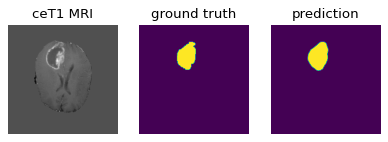

current epoch: 76 current mean dice: 0.8765
best mean dice: 0.8807 at epoch: 68
----------
epoch 77/150
epoch 77 average loss: 0.0999
----------
epoch 78/150
epoch 78 average loss: 0.1038
----------
epoch 79/150
epoch 79 average loss: 0.1130
----------
epoch 80/150
epoch 80 average loss: 0.0996
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_205_1/t1ce.nii.gz']


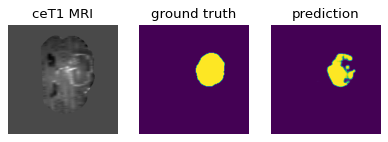

saved new best metric model
current epoch: 80 current mean dice: 0.8896
best mean dice: 0.8896 at epoch: 80
----------
epoch 81/150
epoch 81 average loss: 0.0911
----------
epoch 82/150
epoch 82 average loss: 0.1034
----------
epoch 83/150
epoch 83 average loss: 0.0942
----------
epoch 84/150
epoch 84 average loss: 0.1099
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


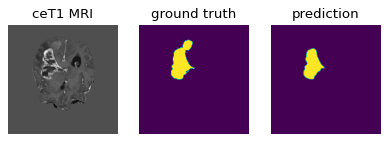

current epoch: 84 current mean dice: 0.8831
best mean dice: 0.8896 at epoch: 80
----------
epoch 85/150
epoch 85 average loss: 0.0998
----------
epoch 86/150
epoch 86 average loss: 0.0913
----------
epoch 87/150
epoch 87 average loss: 0.1101
----------
epoch 88/150
epoch 88 average loss: 0.1023
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


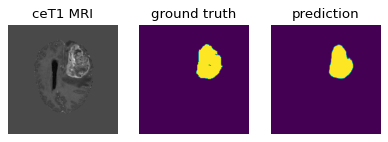

current epoch: 88 current mean dice: 0.8802
best mean dice: 0.8896 at epoch: 80
----------
epoch 89/150
epoch 89 average loss: 0.1086
----------
epoch 90/150
epoch 90 average loss: 0.0934
----------
epoch 91/150
epoch 91 average loss: 0.0951
----------
epoch 92/150
epoch 92 average loss: 0.0913
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_278_1/t1ce.nii.gz']


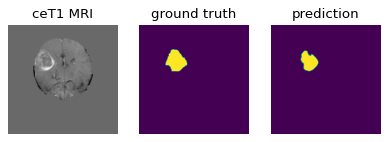

saved new best metric model
current epoch: 92 current mean dice: 0.9016
best mean dice: 0.9016 at epoch: 92
----------
epoch 93/150


In [ ]:
path1 = "/content/drive/Shareddrives/Project/pth/"
root_dir = path1 # model will be saved in this folder

lr = 1e-4   ########되도록이면 수정하지말기! 대부분의 모델이 lr이거임
max_epochs = 150
val_interval = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

optimizer = torch.optim.Adam(model.parameters(), lr) #######lr자리에 다른거 넣어보기

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"],
        )

        #label을 결정하는 과정 : 1을 가지는것 + 2를 가지는것 + 4를 가지는것
        #-> 우리프로젝트는 1, 4를 구분해야함 (고려사항)
        labels = (labels==1).type(torch.FloatTensor) + (labels==4).type(torch.FloatTensor)
        labels[labels>0] = 1
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            disp_val_no = np.random.randint(len(valid_files))
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"],
                )        

                val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
                val_labels[val_labels>0] = 1
                val_labels = val_labels.to(device)
                
                roi_size = (160, 160, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
                val_loss = loss_function(val_outputs, val_labels)
                
                metric_count += 1
                metric_sum += (1-val_loss.sum().item())
                
                if metric_count == disp_val_no:
                  print(val_data['image_meta_dict']['filename_or_obj'])
                  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
                  val_preds = val_outputs.softmax(1)
                  plt.figure(dpi=dpiv)
                  plt.subplot(131)
                  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
                  plt.axis('off')
                  plt.title('ceT1 MRI')
                  plt.subplot(132)
                  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('ground truth')
                  plt.subplot(133)
                  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('prediction')
                  plt.show()
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, f"best_metric_model_epoch_box_L77_3.pth")) 
                #학습된 파라미터 모델 저장   
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}")

epoch 92 까지 돌린 후 이어 진행하기 위하여 위의 실행결과 나온 pth 파일을 불러와 사용하였습니다

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

#UNet의 모델을 바꿔도되고, 파라미터값을 바꿔도되고
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2, #tumor & background
    channels=(16, 32, 64, 128, 256),
    #channels=(8, 16, 32, 64),
    #channels=(16, 32, 64, 128),#8,16,32,64
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)  #sigmoid? 성능 괜찮은데 나중에 저장하는데 argmax말고 딴거해야할듯
#loss_function = DiceCELoss(include_background=False, softmax = True, to_onehot_y = True)


In [ ]:
root_dir = '/content/drive/Shareddrives/Project/pth'
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_epoch_box_L77_3.pth")))

<All keys matched successfully>

----------
epoch 93/150
epoch 93 average loss: 0.1002
----------
epoch 94/150
epoch 94 average loss: 0.0872
----------
epoch 95/150
epoch 95 average loss: 0.0866
----------
epoch 96/150
epoch 96 average loss: 0.0926
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


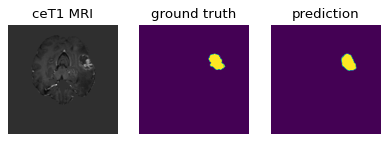

saved new best metric model
current epoch: 96 current mean dice: 0.8913
best mean dice: 0.8913 at epoch: 96
----------
epoch 97/150
epoch 97 average loss: 0.0956
----------
epoch 98/150
epoch 98 average loss: 0.0868
----------
epoch 99/150
epoch 99 average loss: 0.0900
----------
epoch 100/150
epoch 100 average loss: 0.0918
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


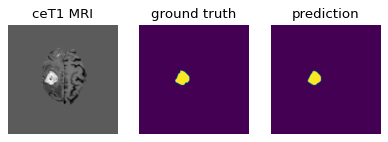

current epoch: 100 current mean dice: 0.8894
best mean dice: 0.8913 at epoch: 96
----------
epoch 101/150
epoch 101 average loss: 0.0874
----------
epoch 102/150
epoch 102 average loss: 0.0834
----------
epoch 103/150
epoch 103 average loss: 0.0988
----------
epoch 104/150
epoch 104 average loss: 0.0930
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_111_1/t1ce.nii.gz']


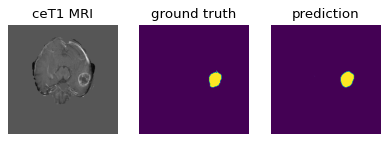

saved new best metric model
current epoch: 104 current mean dice: 0.9002
best mean dice: 0.9002 at epoch: 104
----------
epoch 105/150
epoch 105 average loss: 0.0872
----------
epoch 106/150
epoch 106 average loss: 0.0905
----------
epoch 107/150
epoch 107 average loss: 0.0925
----------
epoch 108/150
epoch 108 average loss: 0.0907
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


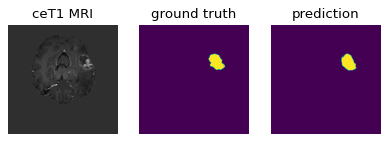

current epoch: 108 current mean dice: 0.8901
best mean dice: 0.9002 at epoch: 104
----------
epoch 109/150
epoch 109 average loss: 0.1030
----------
epoch 110/150
epoch 110 average loss: 0.0957
----------
epoch 111/150
epoch 111 average loss: 0.0994
----------
epoch 112/150
epoch 112 average loss: 0.0998
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


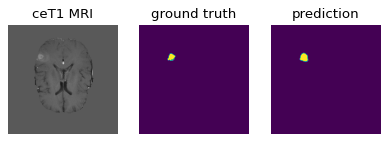

current epoch: 112 current mean dice: 0.8996
best mean dice: 0.9002 at epoch: 104
----------
epoch 113/150
epoch 113 average loss: 0.0881
----------
epoch 114/150
epoch 114 average loss: 0.0923
----------
epoch 115/150
epoch 115 average loss: 0.0805
----------
epoch 116/150
epoch 116 average loss: 0.0874
current epoch: 116 current mean dice: 0.8962
best mean dice: 0.9002 at epoch: 104
----------
epoch 117/150
epoch 117 average loss: 0.0888
----------
epoch 118/150
epoch 118 average loss: 0.0808
----------
epoch 119/150
epoch 119 average loss: 0.0795
----------
epoch 120/150
epoch 120 average loss: 0.0872
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA06_165_1/t1ce.nii.gz']


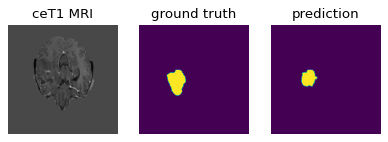

current epoch: 120 current mean dice: 0.8997
best mean dice: 0.9002 at epoch: 104
----------
epoch 121/150
epoch 121 average loss: 0.0804
----------
epoch 122/150
epoch 122 average loss: 0.0920
----------
epoch 123/150
epoch 123 average loss: 0.0892
----------
epoch 124/150
epoch 124 average loss: 0.0868
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA05_277_1/t1ce.nii.gz']


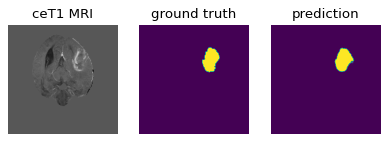

current epoch: 124 current mean dice: 0.8937
best mean dice: 0.9002 at epoch: 104
----------
epoch 125/150
epoch 125 average loss: 0.0728
----------
epoch 126/150
epoch 126 average loss: 0.0847
----------
epoch 127/150
epoch 127 average loss: 0.0898
----------
epoch 128/150
epoch 128 average loss: 0.0791
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


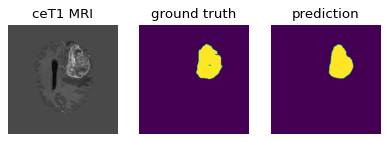

saved new best metric model
current epoch: 128 current mean dice: 0.9064
best mean dice: 0.9064 at epoch: 128
----------
epoch 129/150
epoch 129 average loss: 0.0994
----------
epoch 130/150
epoch 130 average loss: 0.0782
----------
epoch 131/150
epoch 131 average loss: 0.0802
----------
epoch 132/150
epoch 132 average loss: 0.0810
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


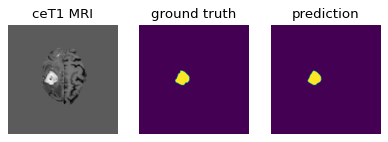

current epoch: 132 current mean dice: 0.9055
best mean dice: 0.9064 at epoch: 128
----------
epoch 133/150
epoch 133 average loss: 0.0897
----------
epoch 134/150
epoch 134 average loss: 0.0712
----------
epoch 135/150
epoch 135 average loss: 0.0836
----------
epoch 136/150
epoch 136 average loss: 0.0804
saved new best metric model
current epoch: 136 current mean dice: 0.9153
best mean dice: 0.9153 at epoch: 136
----------
epoch 137/150
epoch 137 average loss: 0.0831
----------
epoch 138/150
epoch 138 average loss: 0.0774
----------
epoch 139/150
epoch 139 average loss: 0.0904
----------
epoch 140/150
epoch 140 average loss: 0.0781
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA06_165_1/t1ce.nii.gz']


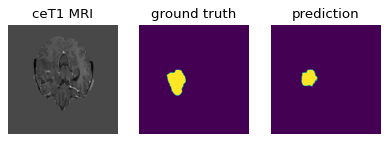

current epoch: 140 current mean dice: 0.9116
best mean dice: 0.9153 at epoch: 136
----------
epoch 141/150
epoch 141 average loss: 0.0733
----------
epoch 142/150
epoch 142 average loss: 0.0881
----------
epoch 143/150
epoch 143 average loss: 0.0868
----------
epoch 144/150
epoch 144 average loss: 0.0852
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


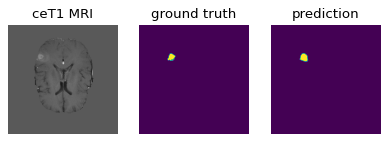

current epoch: 144 current mean dice: 0.8997
best mean dice: 0.9153 at epoch: 136
----------
epoch 145/150
epoch 145 average loss: 0.0840
----------
epoch 146/150
epoch 146 average loss: 0.0861
----------
epoch 147/150
epoch 147 average loss: 0.0708
----------
epoch 148/150
epoch 148 average loss: 0.0795
['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


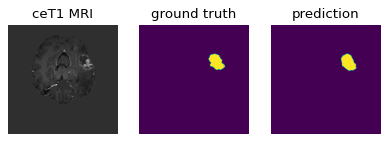

current epoch: 148 current mean dice: 0.8980
best mean dice: 0.9153 at epoch: 136
----------
epoch 149/150
epoch 149 average loss: 0.0872
----------
epoch 150/150
epoch 150 average loss: 0.0896


In [ ]:
path1 = "/content/drive/Shareddrives/Project/pth/"
root_dir = path1

lr = 1e-4   ########되도록이면 수정하지말기! 대부분의 모델이 lr이거임
max_epochs = 58
val_interval = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

optimizer = torch.optim.Adam(model.parameters(), lr) #######lr자리에 다른거 넣어보기

for epoch in range(0,max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 93}/{max_epochs+92}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"],
        )
        #label을 결정하는 과정 : 1을 가지는것 + 2를 가지는것 + 4를 가지는것
        #-> 우리프로젝트는 1, 4를 구분해야함 (고려사항)
        labels = (labels==1).type(torch.FloatTensor) + (labels==4).type(torch.FloatTensor)
        labels[labels>0] = 1
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 93} average loss: {epoch_loss:.4f}")
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            disp_val_no = np.random.randint(len(valid_files))
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"],
                )        

                val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
                val_labels[val_labels>0] = 1
                val_labels = val_labels.to(device)
                
                roi_size = (160, 160, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
                val_loss = loss_function(val_outputs, val_labels)
                
                metric_count += 1
                metric_sum += (1-val_loss.sum().item())
                
                if metric_count == disp_val_no:
                  print(val_data['image_meta_dict']['filename_or_obj'])
                  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
                  val_preds = val_outputs.softmax(1)
                  plt.figure(dpi=dpiv)
                  plt.subplot(131)
                  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
                  plt.axis('off')
                  plt.title('ceT1 MRI')
                  plt.subplot(132)
                  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('ground truth')
                  plt.subplot(133)
                  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('prediction')
                  plt.show()
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, f"best_metric_model_epoch_box_L77_3.pth")) 
                #학습된 파라미터 모델 저장   
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 93} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch + 92}")

## plot the loss and metric

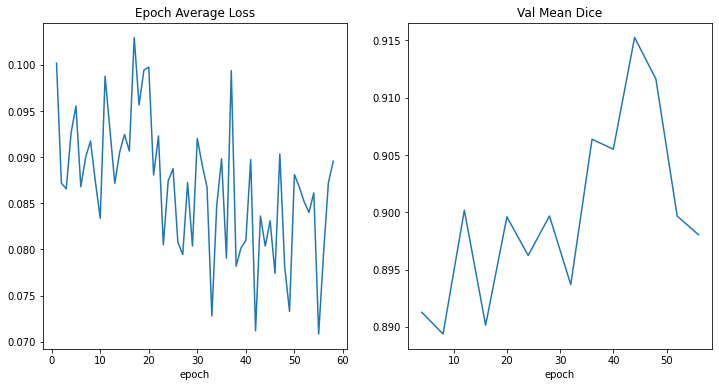

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

여기서부터 아래 코드는 별도의 inference ipynb파일로 저장해뒀습니다.

# Inference
- validation set 에 대해 가장 좋은 성능을 보여주었던 model을 불러와서 inference를 진행하고, 결과를 nifti파일로 저장합니다.

In [ ]:
import nibabel as nib
pathh = "/content/drive/Shareddrives/Project/valid_out"
#pathh = "/content/drive/Shareddrives/Project/test_out"

path_out = os.path.join(pathh,'L77_3') # the results will be saved in this folder
if os.path.isdir(path_out)==0:
  os.mkdir(path_out)

In [ ]:
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2, #tumor & background
    channels=(16, 32, 64, 128, 256),
    #channels=(8, 16, 32, 64),
    #channels=(16, 32, 64, 128),#8,16,32,64
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


root_dir = '/content/drive/Shareddrives/Project/pth'
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_epoch_box_L77_3.pth")))
#저장한 모델을 불러오는 과정, 모델을 정의하는 과정은 있어야됨(model = UNet( ),todevice -이거)

<All keys matched successfully>

In [ ]:
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


validation set에 대한 평가

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_138_1/t1ce.nii.gz']


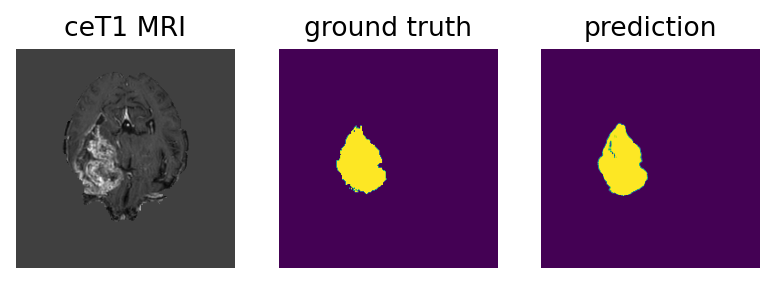

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_257_1/t1ce.nii.gz']


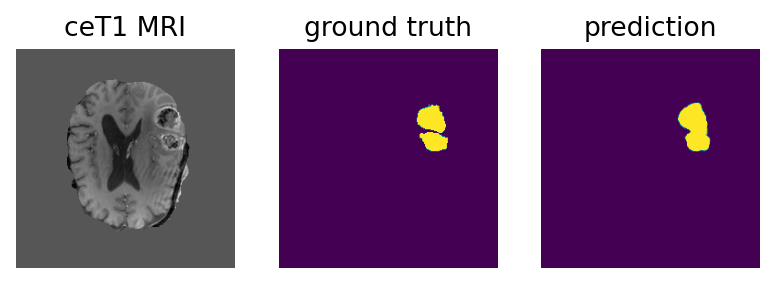

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_296_1/t1ce.nii.gz']


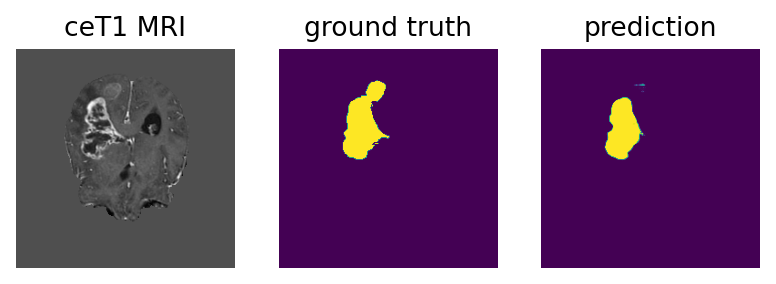

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_375_1/t1ce.nii.gz']


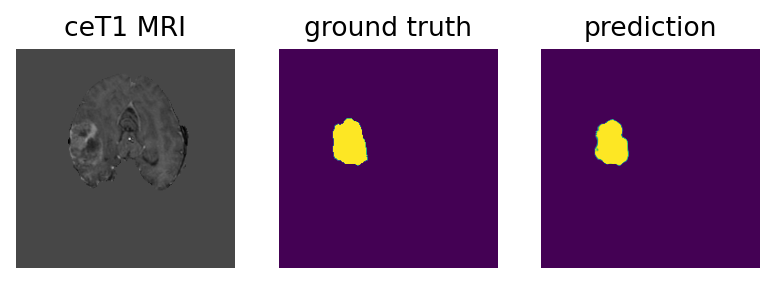

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA03_474_1/t1ce.nii.gz']


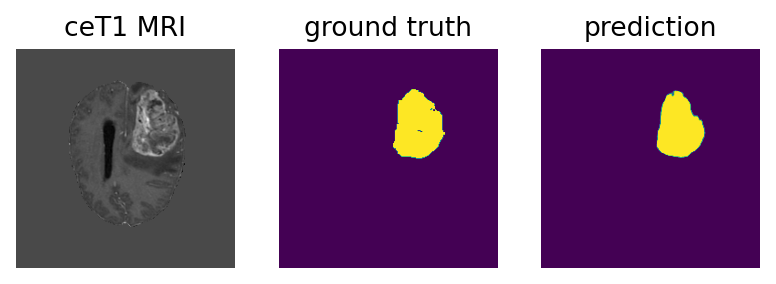

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_111_1/t1ce.nii.gz']


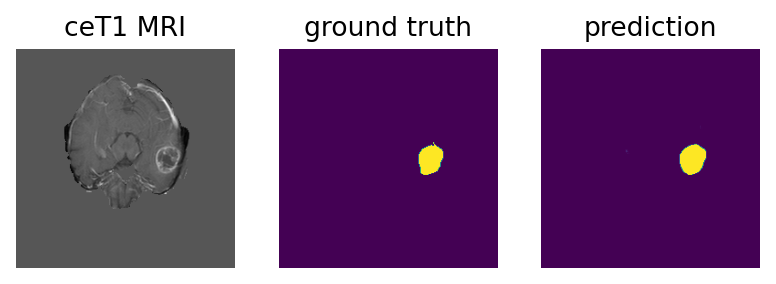

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_192_1/t1ce.nii.gz']


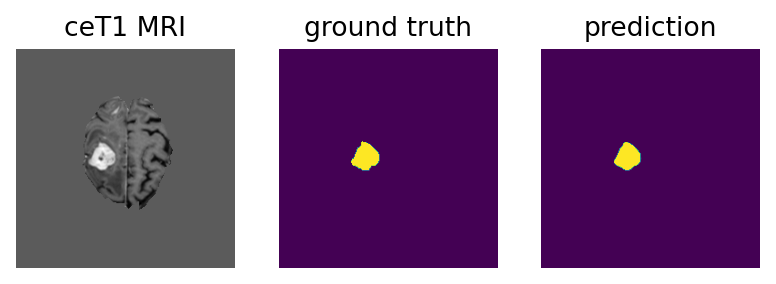

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_343_1/t1ce.nii.gz']


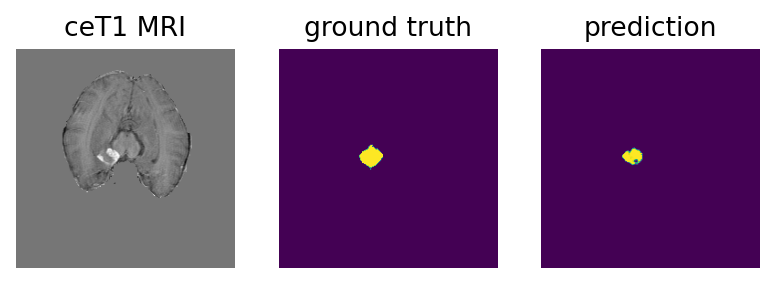

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA04_437_1/t1ce.nii.gz']


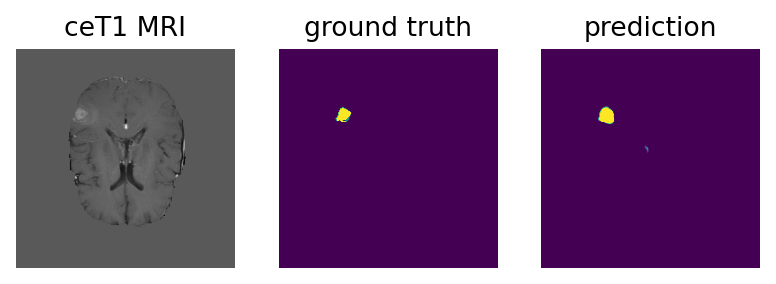

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA05_277_1/t1ce.nii.gz']


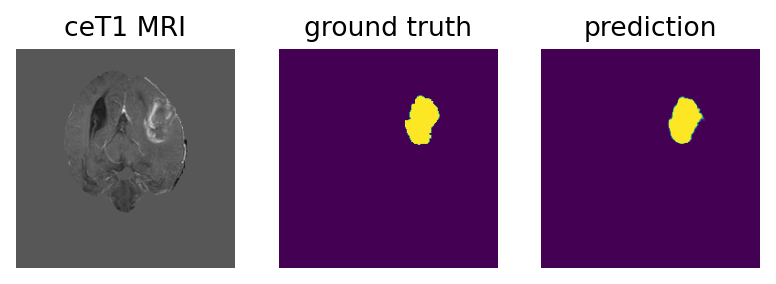

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA05_444_1/t1ce.nii.gz']


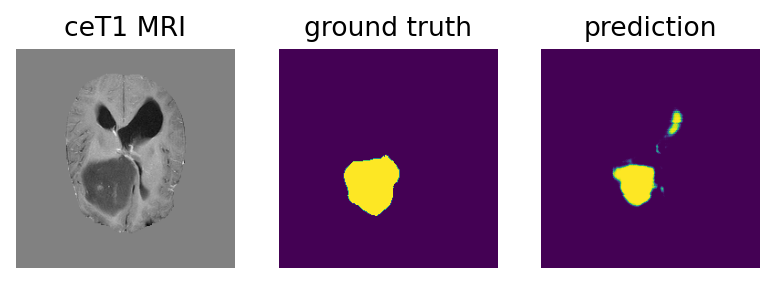

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA06_165_1/t1ce.nii.gz']


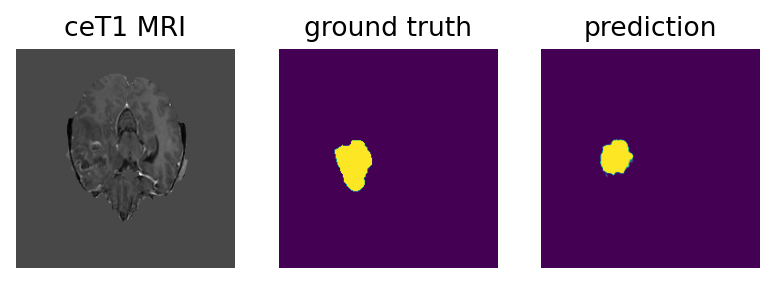

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA06_211_1/t1ce.nii.gz']


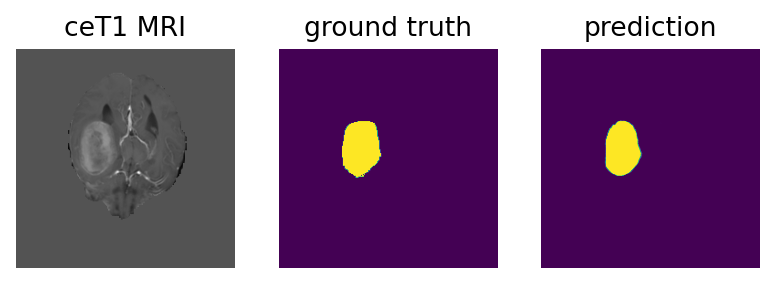

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA06_332_1/t1ce.nii.gz']


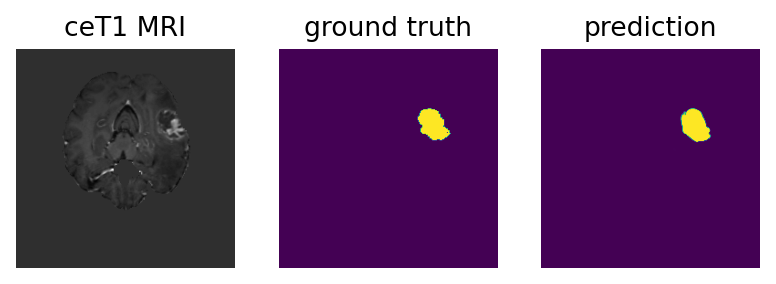

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_105_1/t1ce.nii.gz']


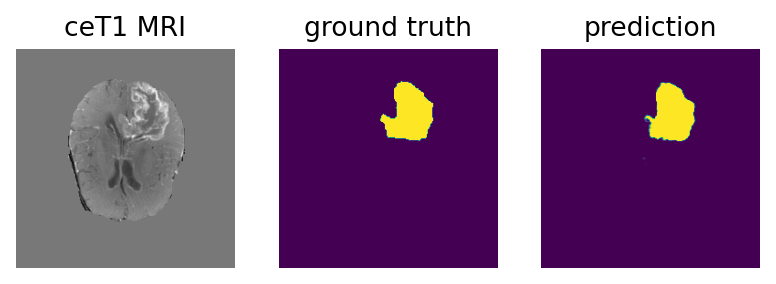

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_162_1/t1ce.nii.gz']


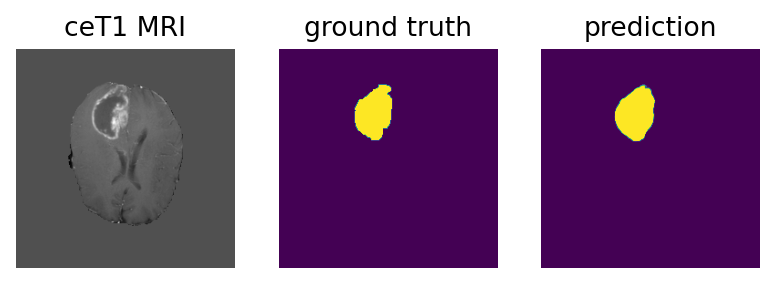

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_205_1/t1ce.nii.gz']


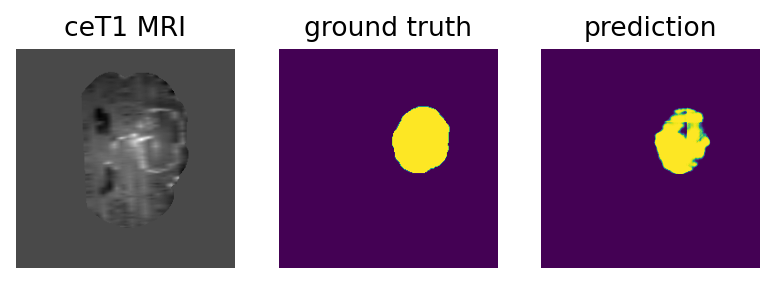

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_234_1/t1ce.nii.gz']


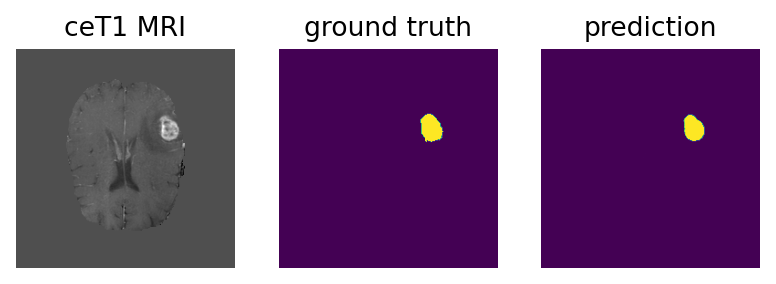

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_278_1/t1ce.nii.gz']


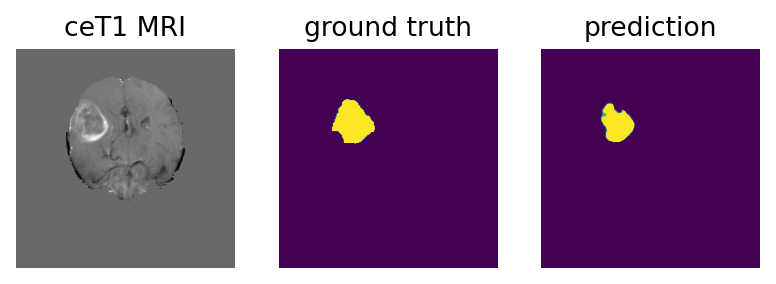

['/content/drive/Shareddrives/Project/brats18_train/Brats18_TCIA08_319_1/t1ce.nii.gz']


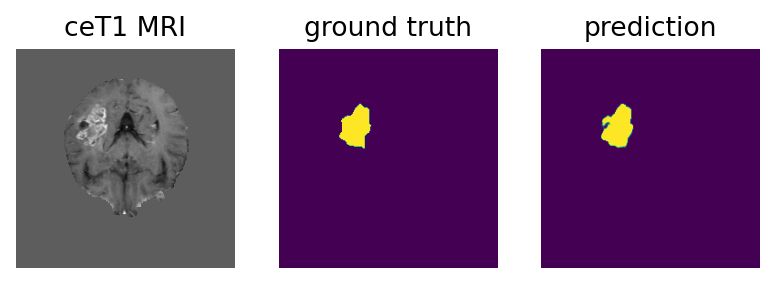

In [ ]:
model.eval()
flag_save = 1
for val_data in valid_loader:
  with torch.no_grad():
    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"],
                    )        
    val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
    val_labels[val_labels>0] = 1
    val_labels = val_labels.to(device)
    roi_size = (160, 160, 64)
    sw_batch_size = 4
    val_outputs = sliding_window_inference(
    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
    val_loss = loss_function(val_outputs, val_labels)

    
    print(val_data['image_meta_dict']['filename_or_obj'])
    zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
    val_preds = val_outputs.softmax(1)
    plt.figure(dpi=dpiv*2)
    plt.subplot(131)
    plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
    plt.axis('off')
    plt.title('ceT1 MRI')
    plt.subplot(132)
    plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
    plt.axis('off')
    plt.title('ground truth')
    plt.subplot(133)
    plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
    plt.axis('off')
    plt.title('prediction')
    plt.show()

#nifti파일 저장시 이거 주석풀기
    if flag_save == 1:
      val_seg = torch.argmax(val_preds.cpu(),dim=1).numpy()
      pid = val_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
      h = nib.load(val_data['image_meta_dict']['filename_or_obj'][0])
      h_new=nib.Nifti1Image(val_seg[0],h.affine,h.header)
      nib.save(h_new,os.path.join(path_out,pid+'.nii.gz')) #nifti 파일을 만드는 과정


In [ ]:
ppath = '/content/drive/Shareddrives/Project/valid_out/L77_3'
filename = os.listdir(ppath)
print(len(filename))

20


In [ ]:
import nibabel as nib
import numpy as np


for niifn in filename:
  proxy = nib.load(os.path.join('/content/drive/Shareddrives/Project/valid_out/L77_3/'+niifn))
  data = proxy.get_fdata()
  array = data.view(type=np.ndarray)
  # np.flip(array,0) -> 좌우대칭 RL
  # np.flip(array,1) -> 앞뒤대칭 AP 
  # np.flip(array,2) -> 상하대칭 IS
  array_flip = np.flip(array,0)
  array_flip = np.flip(array_flip,1)
  #array_flip = np.flip(array_flip,2)

  aff = proxy.affine
  hdr = proxy.header


  zflip = nib.Nifti1Image(array_flip,aff, hdr)
  path_r = '/content/drive/Shareddrives/Project/valid_out/'
  path_reverse = os.path.join(path_r,'L77_reverse_3') # the results will be saved in this folder
  if os.path.isdir(path_reverse)==0:
    os.mkdir(path_reverse)
  nib.save(zflip, os.path.join('/content/drive/Shareddrives/Project/valid_out/L77_reverse_3/'+niifn[:-7]+'.nii.gz'))


testset에 대한 평가

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_02/t1ce.nii.gz']


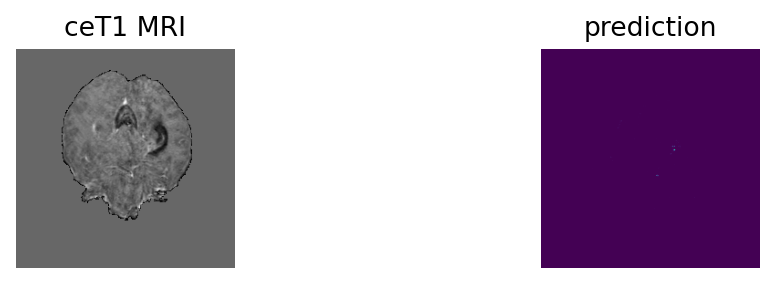

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_04/t1ce.nii.gz']


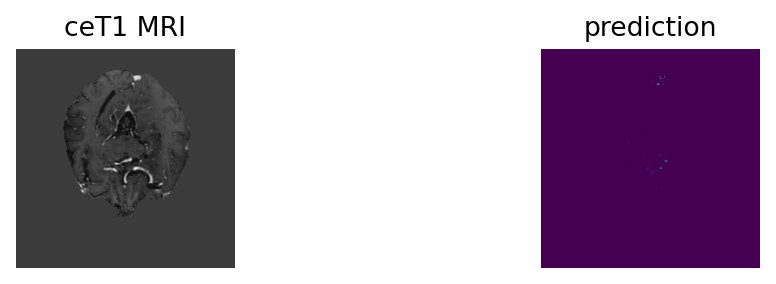

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_05/t1ce.nii.gz']


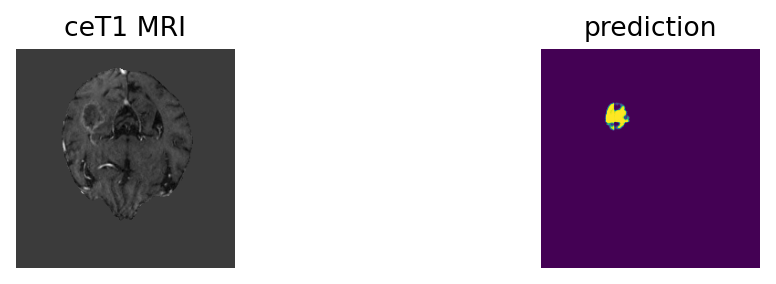

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_10/t1ce.nii.gz']


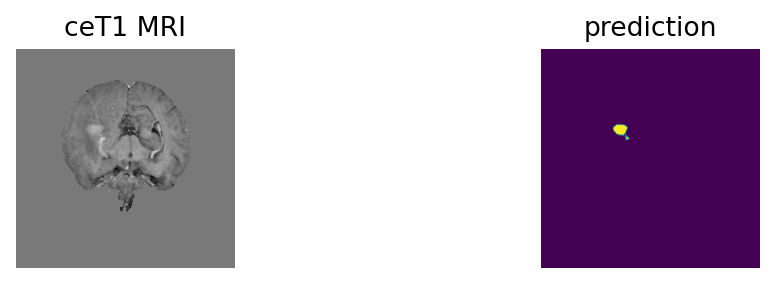

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_09/t1ce.nii.gz']


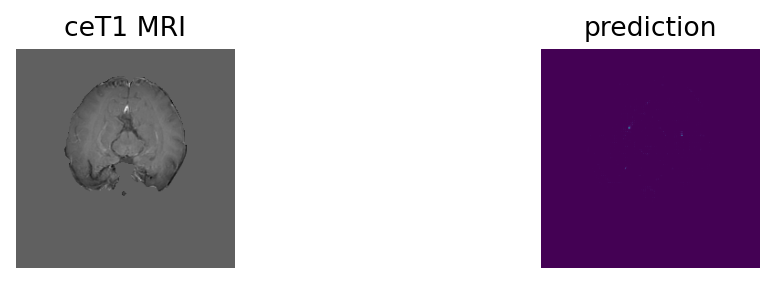

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_07/t1ce.nii.gz']


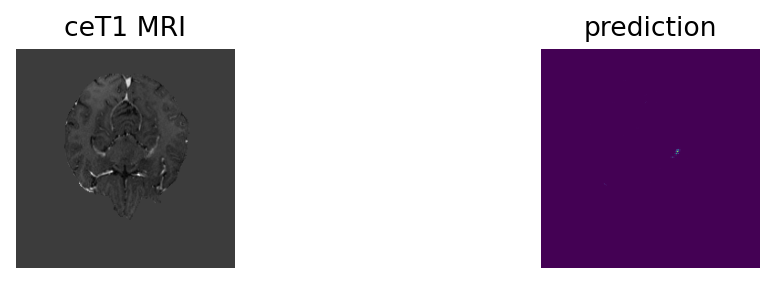

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_06/t1ce.nii.gz']


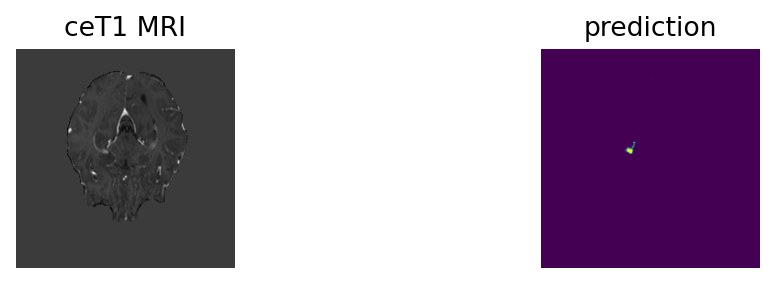

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_01/t1ce.nii.gz']


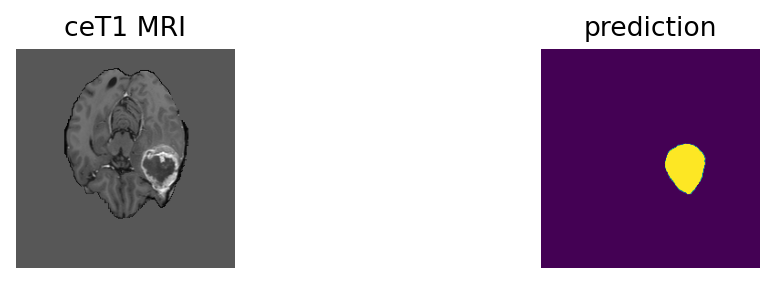

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_03/t1ce.nii.gz']


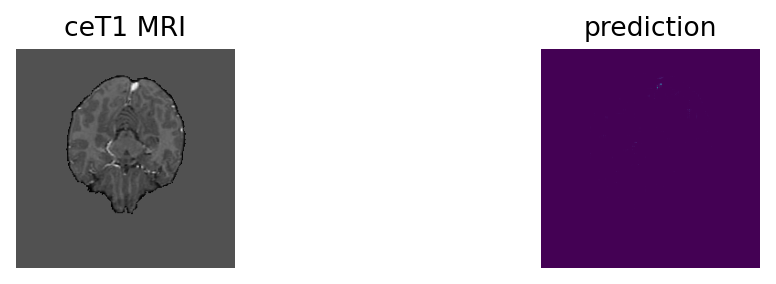

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_08/t1ce.nii.gz']


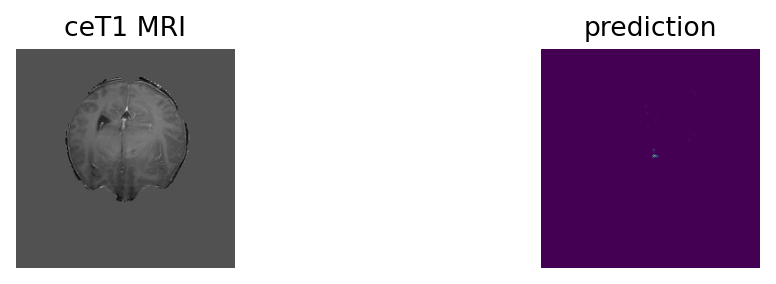

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_13/t1ce.nii.gz']


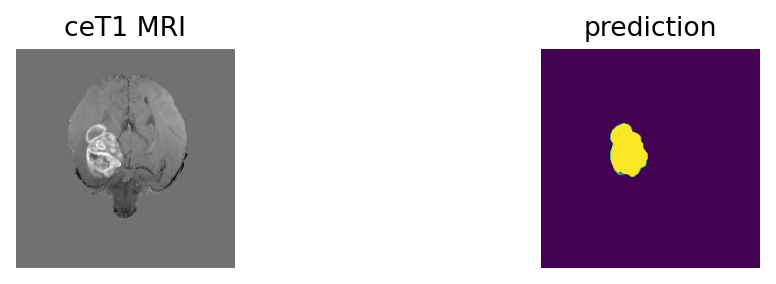

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_14/t1ce.nii.gz']


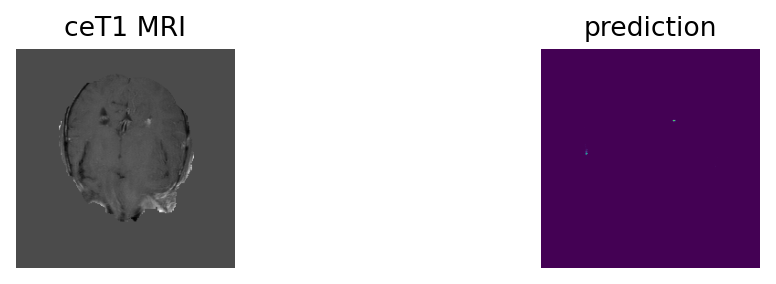

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_19/t1ce.nii.gz']


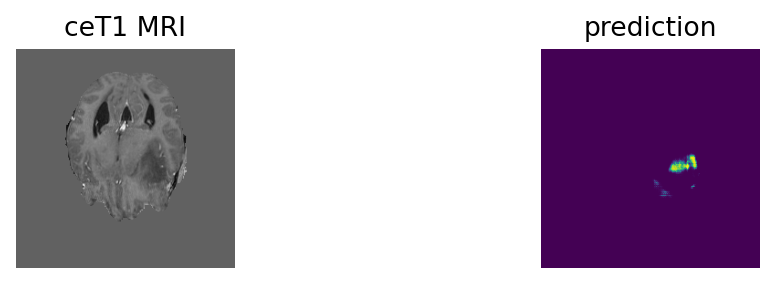

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_20/t1ce.nii.gz']


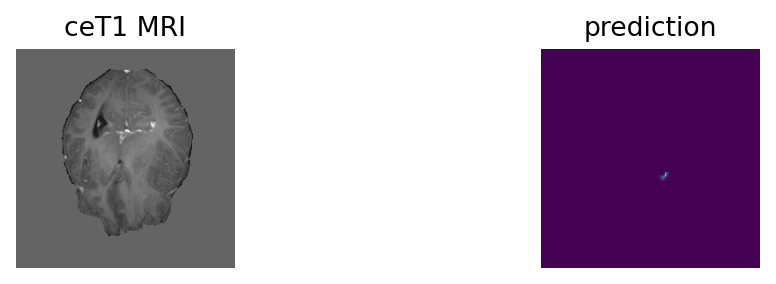

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_17/t1ce.nii.gz']


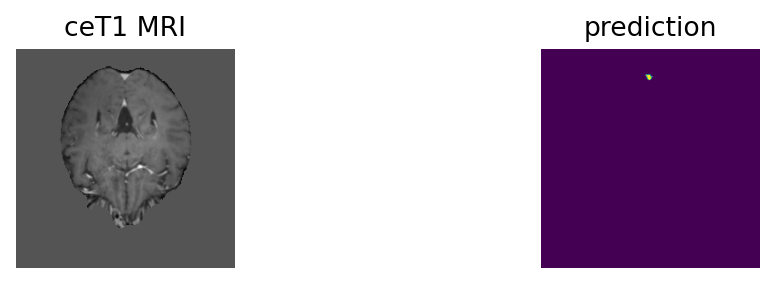

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_18/t1ce.nii.gz']


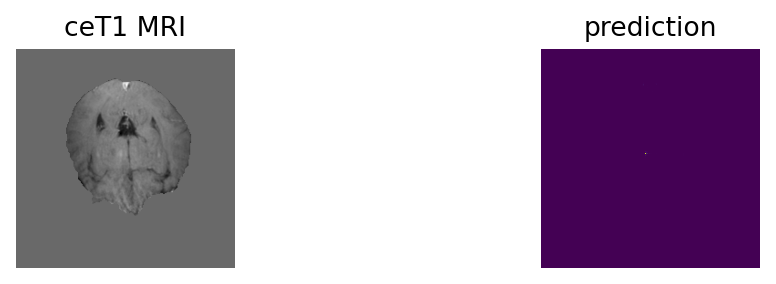

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_15/t1ce.nii.gz']


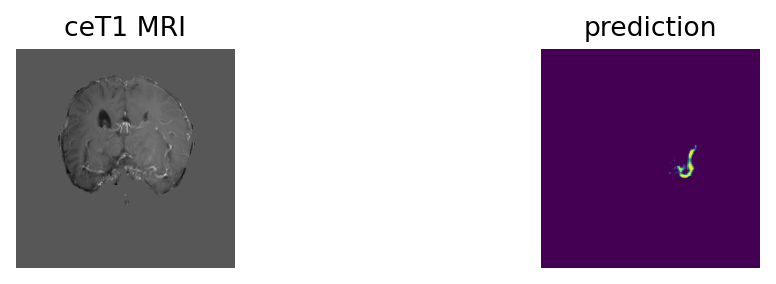

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_16/t1ce.nii.gz']


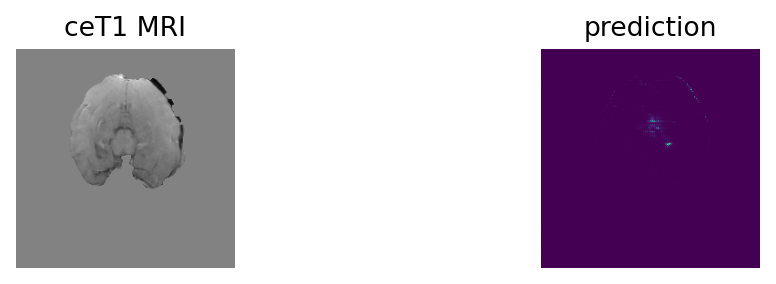

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_11/t1ce.nii.gz']


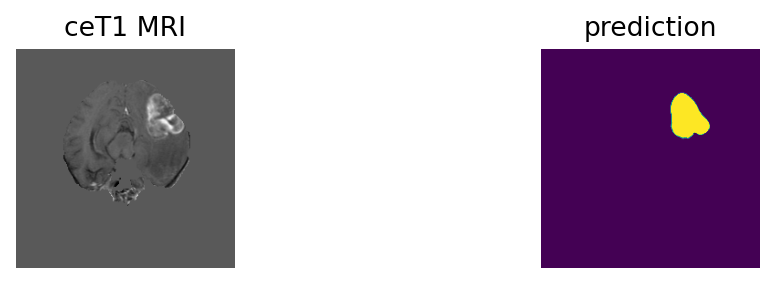

['/content/drive/Shareddrives/Project/brats18_test/Brats18_test_12/t1ce.nii.gz']


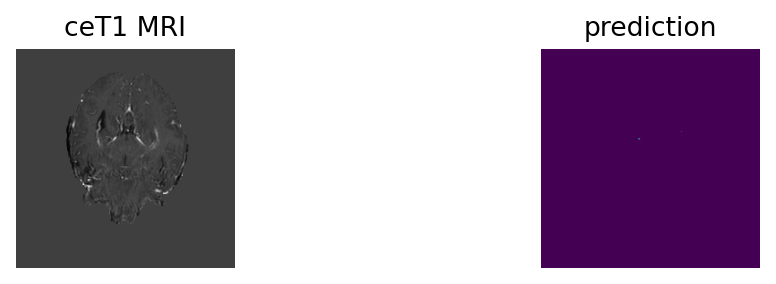

In [ ]:
#pathh = "/content/drive/Shareddrives/Project/valid_out"
pathh = "/content/drive/Shareddrives/Project/test_out"

path_out = os.path.join(pathh,'L77_3') # the results will be saved in this folder
if os.path.isdir(path_out)==0:
  os.mkdir(path_out)

flag_save = 1
for test_data in test_loader:
  with torch.no_grad():
    test_inputs = test_data["image"].to(device)

    #val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
    #val_labels[val_labels>0] = 1
    #val_labels = val_labels.to(device)
    roi_size = (160, 160, 64)
    sw_batch_size = 4
    test_outputs = sliding_window_inference(
    test_inputs, roi_size, sw_batch_size, model, overlap=0.75)
    #test_loss = loss_function(test_outputs)
    
    print(test_data['image_meta_dict']['filename_or_obj'])
    zz=58
    #zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
    test_preds = test_outputs.softmax(1)
    plt.figure(dpi=dpiv*2)
    plt.subplot(131)
    plt.imshow(np.transpose(test_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
    plt.axis('off')
    plt.title('ceT1 MRI')
    #plt.subplot(132)
    #plt.imshow(np.transpose(_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
    #plt.axis('off')
    #plt.title('ground truth')
    plt.subplot(133)
    plt.imshow(np.transpose(test_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
    plt.axis('off')
    plt.title('prediction')
    plt.show()

    if flag_save == 1:
      test_seg = torch.argmax(test_preds.cpu(),dim=1).numpy()
      pid = test_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
      h = nib.load(test_data['image_meta_dict']['filename_or_obj'][0])
      h_new=nib.Nifti1Image(test_seg[0],h.affine,h.header)
      nib.save(h_new,os.path.join(path_out,pid+'.nii.gz')) #nifti 파일을 만드는 과정'''

In [ ]:
ppath = '/content/drive/Shareddrives/Project/test_out/L77_3'
filename = os.listdir(ppath)
print(len(filename))

20


In [ ]:
import nibabel as nib
import numpy as np


for niifn in filename:
  proxy = nib.load(os.path.join('/content/drive/Shareddrives/Project/test_out/L77_3/'+niifn))
  data = proxy.get_fdata()
  array = data.view(type=np.ndarray)
  # np.flip(array,0) -> 좌우대칭 RL
  # np.flip(array,1) -> 앞뒤대칭 AP 
  # np.flip(array,2) -> 상하대칭 IS
  array_flip = np.flip(array,0)
  array_flip = np.flip(array_flip,1)
  #array_flip = np.flip(array_flip,2)

  aff = proxy.affine
  hdr = proxy.header


  zflip = nib.Nifti1Image(array_flip,aff, hdr)
  path_tr = '/content/drive/Shareddrives/Project/test_out/'
  path_treverse = os.path.join(path_tr,'L77_reverse_3') # the results will be saved in this folder
  if os.path.isdir(path_treverse)==0:
    os.mkdir(path_treverse)
  #nib.save(zflip, os.path.join('/content/drive/Shareddrives/Project/valid_out/L7_reverse_150/'+niifn[:-7]+'.nii.gz'))
  nib.save(zflip, os.path.join('/content/drive/Shareddrives/Project/test_out/L77_reverse_3/'+niifn[:-7]+'.nii.gz'))
